[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Enter a keyword or 'quit' to exit: 3
Searching for: 3


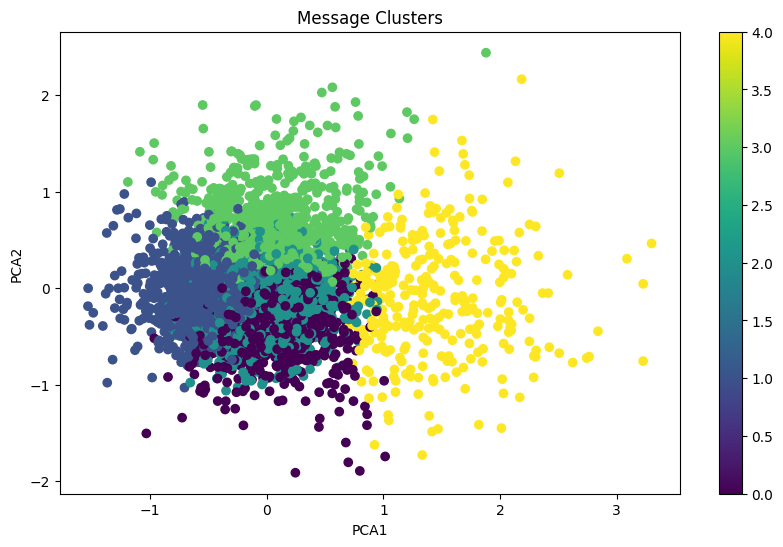

Enter a keyword or 'quit' to exit: quit


In [4]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
import spacy
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import schedule
import time
import nltk
import mysql.connector
from mysql.connector import Error
nltk.download('punkt')

# Load data
data = pd.read_csv("/content/Posts.csv")
data.drop_duplicates(subset=['Title', 'Post URL', 'Total Comments', 'ID'], inplace=True)
data.drop("Unnamed: 0", axis=1, inplace=True)


# Database connection function
def fetch_portfolio_data(host='localhost', user='root', password='your_password', database='Reddit_data'):
    try:
        # Establishing the connection
        conn = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        print("MySQL Database connection successful")
    except Error as e:
        print(f"The error '{e}' occurred")
    return conn


# Preprocessing functions
def extract_domain(url):
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
        if domain.startswith('www.'): domain = domain[4:]
        if domain.endswith(".com"): domain = domain[:-4]
        return domain
    except Exception as e:
        return None

nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

def extract_keywords_and_topics(title):
    doc = nlp(title)
    keywords = [token.text.lower() for token in doc if token.text.lower() not in stop_words and not token.is_punct]
    topics = [chunk.text for chunk in doc.noun_chunks]
    return {'Keywords': ', '.join(keywords), 'Topics': ', '.join(topics)}

# Apply preprocessing
data['Domain URL'] = data['Post URL'].apply(extract_domain)
data[['Keywords', 'Topics']] = data['Title'].apply(lambda x: pd.Series(extract_keywords_and_topics(x)))

# Doc2Vec
documents = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(data['Title'])]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4, epochs=40)
data['doc2vec_vector'] = [model.infer_vector(word_tokenize(doc.lower())) for doc in data['Title']]

# Clustering
num_clusters = 5  # Adjust based on your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(list(data['doc2vec_vector']))
data['cluster_label'] = kmeans.labels_

# Visualization
def visualize_clusters():
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(list(data['doc2vec_vector']))
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=data['cluster_label'])
    plt.title('Message Clusters')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.colorbar()
    plt.show()

# Scheduling and user interaction
def scheduled_job():
    # Placeholder for data fetching, processing, updating logic
    print("Database updated.")

schedule.every(5).minutes.do(scheduled_job)

if __name__ == "__main__":
    while True:
        schedule.run_pending()
        time.sleep(10)  # Check every 10 seconds for demonstration; adjust as needed
        user_input = input("Enter a keyword or 'quit' to exit: ").strip().lower()
        if user_input == 'quit':
            break
        else:
            # Placeholder for finding and displaying the closest cluster and its messages based on user input
            print("Searching for:", user_input)
            # Here, you would implement the logic to find the closest cluster based on the user input
            # This could involve computing similarity scores between the user input and cluster centroids or keywords
            visualize_clusters()  # Optionally visualize clusters for each search


In [ ]:
import nltk
nltk.download('punkt')

In [2]:
pip install schedule